<a href="https://colab.research.google.com/github/neworderofjamie/riscv_ise/blob/master/tutorials/alif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are lots of rough edges here: error checking is lacking in places, the compiler supports an even smaller subset of C than it should and the wrapping of various bits of API is not very Pythonic.

# Installation
The current prototype FeNN toolchain is a little bit tricky to build as it re-uses parts of GeNN (mostly the type system and the GeNNCode scanner, parser and type checker) so, on colab, we can install a prebuilt wheel from my google drive:

In [1]:
if "google.colab" in str(get_ipython()):
    !gdown 1aO3CLhWJeoDXJ-lb7FqrtxDy-7WRsNYK
    !pip install pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=1aO3CLhWJeoDXJ-lb7FqrtxDy-7WRsNYK
To: /content/pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl
100% 6.55M/6.55M [00:00<00:00, 17.2MB/s]
Processing ./pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pyfenn import (BackendFeNNSim, EventContainer, Model, NeuronUpdateProcess,
                    Parameter, PlogSeverity, ProcessGroup, Runtime, Variable)

from pyfenn import disassemble, init_logging
from pyfenn.utils import get_array_view, zero_and_push

# Stimulus generation
To test our ALIF neuron, in a semi-realistic regime, we want to generate some bursty poisson noise to simulate a large number of incoming neurons:

In [4]:
background_rate = 0.5
rate = 7846 / 1370
num_timesteps = 1000

# Generate poisson data with two periods of average firing interspersed by background
data = np.zeros(num_timesteps)
data[0:400] = np.random.poisson(rate, 400)
data[400:600] = np.random.poisson(background_rate, 200)
data[600:] = np.random.poisson(rate, 400)

repeated_data = np.repeat(data[:,None], 32, axis=1).astype(np.int16)

Visualise to see what this looks like:

Text(0.5, 0, 'Time [timestep]')

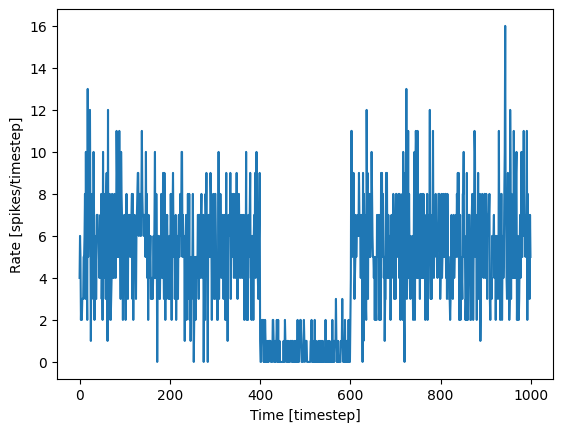

In [5]:
fig, axis = plt.subplots()
axis.plot(data)
axis.set_ylabel("Rate [spikes/timestep]")
axis.set_xlabel("Time [timestep]")

# Layer classes
FeNN is programmed using a small number of primitive objects:
*   ``Processes`` perform computation
*   ``Variables`` are used to hold model state e.g. neuron variables and weights
*   ``EventContainers`` are the primary means of communication between neuron processes

The FeNN tools don't really enforce any particular style of modelling but you can easily use these primitives to create PyTorchesque layer objects. We start by creating a leaky integrator for the output layer. This integrates an input current + bias into a membrane voltage which is averaged over the trial. The update to be performed each timestep is implemented in a ``NeuronUpdateProcess`` which performs the same update to each neuron (as dictated by the same of the variables). In future, these processes might be Just-in-Time compiled from Python but, right now, they are implemented in [GeNNCode](https://genn-team.github.io/genn/documentation/5/custom_models.html#genncode). This is basically a subset of C with extensions for fixed-point types inspired by the [ISO standard extension](https://www.open-std.org/jtc1/sc22/wg14/www/docs/n1005.pdf). Here we define an Adaptive LIF neuron which integrates a tensor of input currents. Fixed-point types are specified as strings, for example s9_6_sat_t is a signed 16-bit fixed point type (this is all FeNN currently supports) with 9 integer and 6 fractional bits to which saturation should be applied (currently only when adding and subtracting):

In [22]:
class ALIF:
    def __init__(self, shape, tau_m: float, tau_a: float, tau_refrac: int,
                 v_thresh: float, beta: float, weight:float, num_timesteps: int):
        self.shape = shape
        v_dtype = "s6_9_sat_t"
        a_dtype = "s6_9_sat_t"
        decay_dtype = "s0_15_sat_t"
        self.v = Variable(self.shape, v_dtype, num_timesteps + 1)
        self.a = Variable(self.shape, a_dtype, num_timesteps + 1)
        self.i = Variable(self.shape, "int16_t", num_timesteps + 1)
        self.refrac_time = Variable(self.shape, "int16_t")
        self.process = NeuronUpdateProcess(
            """
            V = (Alpha * V) + (Weight * I);
            A *= Rho;

            if (RefracTime > 0) {
               RefracTime -= 1;
            }
            else if(V >= (VThresh + (Beta * A))) {
               V -= VThresh;
               A += 1.0h9;
               RefracTime = TauRefrac;
            }
            """,
            {"Alpha": Parameter(np.exp(-1.0 / tau_m), decay_dtype),
             "Rho": Parameter(np.exp(-1.0 / tau_a), decay_dtype),
             "VThresh": Parameter(v_thresh, v_dtype),
             "Beta": Parameter(beta, v_dtype),
             "Weight": Parameter(weight, v_dtype),
             "TauRefrac": Parameter(tau_refrac, "int16_t")},
            {"V": self.v, "A": self.a, "I": self.i, "RefracTime": self.refrac_time})


# Model definition
The FeNN tools can produce lots of helpful logging information so we initialise this system before we do anything else (if you use ``from pyfenn import PlogSeverity`` to import the enum you can then use e.g. ``PlogSeverity.DEBUG`` to control the logging level):

In [23]:
init_logging()


Then create a neuron layer using the classes we defined above:

In [24]:
neurons = ALIF([32], 20.0, 2000, 5, 0.6, 0.0174, 0.01, num_timesteps)

Process groups define computation that can be performed in parallel (in fact, on FeNN it's not but this won't be the case with e.g. GPU backends) so we group our neuron update processes together

In [25]:
neuron_update_processes = ProcessGroup([neurons.process])

# Simulation
Sadly Google has yet to install FeNN nodes into it's cloud so for now we create a simulation backend (if you are lucky enough to be running on a Kria KV260 with the bitstream loaded, you should substitute ``BackendFeNNHW`` here) and use it to create a generic simulation kernel. The control flow of these kernels *will* be fully programmable but for now you can either create a really simple kernel which just runs a list of process groups or a 'simulation' kernel which offloads running a loop over time with a list of process groups in the body and another list that runs at the end (which we use here to copy output classifications off of FeNN)

Now we define a model which groups together all parts of our simulation:

In [12]:
backend = BackendFeNNSim()

In [26]:
model = Model([neuron_update_processes], backend)

In [27]:
code = backend.generate_simulation_kernel([neuron_update_processes],
                                          [], [],
                                          num_timesteps, model)

Now we have some code, we create a ``Runtime`` object to interact with the FeNN. We first use this to allocate the memory required for our model on FeNN:

In [28]:
runtime = Runtime(model, backend)
runtime.allocate()

Now we use some helper functions to zero state variables:

In [29]:
zero_and_push(neurons.v, runtime)
zero_and_push(neurons.a, runtime)
zero_and_push(neurons.refrac_time, runtime)

and some more to copy our input currents (duplicated across all 32 ALIF neurons) to FeNN:

In [31]:
input_i_array, input_i_view = get_array_view(runtime, neurons.i, np.int16)
input_i_view[:-32] = repeated_data.flatten()
input_i_array.push_to_device()

Then we upload the code generated by the backend to FeNN:

In [32]:
runtime.set_instructions(code)

and finally we run our kernel:

In [33]:
runtime.run()

Having filled up all of FeNN's memory with A and V recordings, we now want to access them! The ``Runtime`` object creates a bunch of 'Array' objects which are used to interact with model state so we first get them from the neuron update processes and copy their contents to the host (on real FeNN hardware, this will use the DMA controller):

In [37]:
neurons_v_array, neurons_v_view = get_array_view(runtime, neurons.v,
                                                 np.int16, (-1, 32))
neurons_a_array, neurons_a_view = get_array_view(runtime, neurons.a,
                                                np.int16, (-1, 32))

neurons_v_array.pull_from_device()
neurons_a_array.pull_from_device()

Finally, we can calculate means and standard deviations (only relevant with stochastic rounding) and plot:

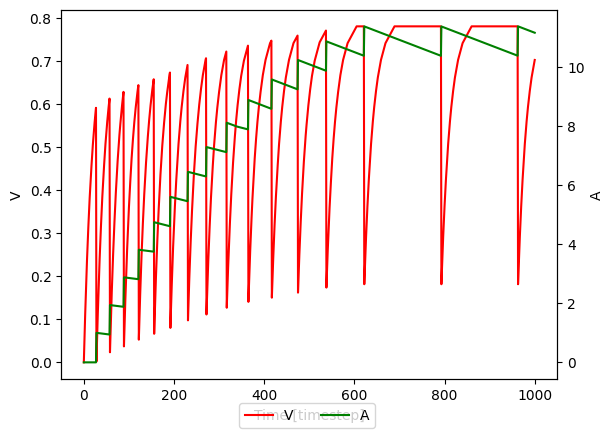

In [38]:
neurons_v_mean = np.average(neurons_v_view, axis=1)
neurons_v_std = np.std(neurons_v_view, axis=1)
neurons_a_mean = np.average(neurons_a_view, axis=1)
neurons_a_std = np.std(neurons_a_view, axis=1)
fig, axis = plt.subplots()

a_axis = axis.twinx()
scale = 1.0 / (2 ** 9)
v_actor = axis.plot(neurons_v_mean * scale, color="red")[0]
a_actor = a_axis.plot(neurons_a_mean * scale, color="green")[0]
fig.legend([v_actor, a_actor], ["V", "A"], loc="lower center", ncols=2)

axis.set_ylabel("V")
a_axis.set_ylabel("A")
axis.set_xlabel("Time [timestep]")

plt.show()

# Disassembling 😥
Sometimes it's cool to know what's happening under the hood so, by using the ``disassemble`` function you can disassemble the code produced be the backend into a slightly friendly form. A slightly outdated description of the instruction set is provided at https://github.com/neworderofjamie/riscv_ise/blob/master/docs/instruction_set.pdf

In [39]:
for i, c in enumerate(code):
    print(f"{i * 4} : {disassemble(c)}")

0 : ADDI X1, X0, 0
4 : ADDI X2, X0, 1000
8 : VLUI V2, 512
12 : VLUI V1, 1
16 : VLUI V0, 0
20 : ADDI X3, X0, 64
24 : LW X4, 4(X0)
28 : LW X5, 8(X0)
32 : MUL X6, X1, X3
36 : ADD X5, X5, X6
40 : ADD X7, X5, X3
44 : LW X6, 12(X0)
48 : MUL X8, X1, X3
52 : ADD X6, X6, X8
56 : ADD X9, X6, X3
60 : LW X8, 16(X0)
64 : MUL X10, X1, X3
68 : ADD X8, X8, X10
72 : ADD X11, X8, X3
76 : VLUI V3, 5
80 : VLUI V4, 5
84 : VLUI V5, 9
88 : VLUI V6, 32752
92 : VLUI V7, 307
96 : VLUI V8, 31170
100 : VLOAD V9, 0(X4)
104 : VLOAD V10, 0(X5)
108 : VLOAD V11, 0(X6)
112 : VLOAD V12, 0(X8)
116 : ADDI X0, X0, 0
120 : VMUL_RN V13, V8, V12, 15
124 : VMUL_RN V14, V4, V10, 0
128 : VADD_S V13, V13, V14
132 : VADD V12, V13, V0
136 : VMUL V11, V11, V6, 15
140 : VTLT X3, V0, V9
144 : VSUB V13, V9, V1
148 : VSEL V9, X3, V13
152 : XORI X10, X3, -1
156 : VMUL_RN V13, V5, V11, 9
160 : VADD_S V13, V7, V13
164 : VTGE X12, V12, V13
168 : AND X13, X10, X12
172 : VSUB_S V13, V12, V7
176 : VSEL V12, X13, V13
180 : VADD_S V13, V11, V2
1